# Применение простейших моделей

Загружаем файлы и необходимые библиотеки

In [1]:
PATH="/content/drive/My Drive/" # Путь до файлов

In [2]:
from google.colab import drive
drive.mount('/content/drive') # Получаем доступ к гугл диску, чтобы взять оттуда данные

Mounted at /content/drive


In [3]:
# Импортируем библиотеки
!pip install optuna
!pip install catboost
!pip install category_encoders
!pip install pickle

import pickle
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

import math

from sklearn.metrics import classification_report,f1_score,precision_score, recall_score, roc_auc_score, auc

from sklearn.model_selection import train_test_split, cross_val_score


from catboost import CatBoostClassifier, Pool
import catboost as cb
from catboost.utils import get_roc_curve


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.5/210.5 KB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 11.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 14.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 9.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [4]:
path_merged_=PATH+"merge_filled_without drop.parquet" # объединенные transaction и identity

merged = pd.read_parquet(path_merged_)

In [5]:
merged.memory_usage().sum() / 1024**2

1955.3709106445312

In [6]:
# Заметим, что все числовые столбцы имели тип int64 или float64.
# В результате объединенный датасет занимает почти 2 GB памяти.
# При обучении моделей google colab периодически падал по памяти, 
# поэтому было решено поработать дополнительно с типами столбцов.


for col in merged.columns:
  col_type = merged[col].dtype

  if col_type != object:
      min_ = merged[col].min()
      max_ = merged[col].max()
      if str(col_type)[:3] == 'int':
          if min_ > np.iinfo(np.int8).min and max_ < np.iinfo(np.int8).max:
              merged[col] = merged[col].astype(np.int8)
          elif min_ > np.iinfo(np.int16).min and max_ < np.iinfo(np.int16).max:
              merged[col] = merged[col].astype(np.int16)
          elif min_ > np.iinfo(np.int32).min and max_ < np.iinfo(np.int32).max:
              merged[col] = merged[col].astype(np.int32)
          elif min_ > np.iinfo(np.int64).min and max_ < np.iinfo(np.int64).max:
              merged[col] = merged[col].astype(np.int64)  
      else:
          if min_ > np.finfo(np.float16).min and max_ < np.finfo(np.float16).max:
              merged[col] = merged[col].astype(np.float16)
          elif min_ > np.finfo(np.float32).min and max_ < np.finfo(np.float32).max:
              merged[col] = merged[col].astype(np.float32)
          else:
              merged[col] = merged[col].astype(np.float64)
  else:
      merged[col] = merged[col].astype('category')


In [7]:
merged.memory_usage().sum() / 1024**2 #Так намного лучше :)

525.5524215698242

In [8]:
merged

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.500000,W,13926,362.5,150.0,discover,142.0,...,n/d,26.515625,n/d,n/d,n/d,n/d,n/d,n/d,n/d,n/d
1,2987001,0,86401,29.000000,W,2755,404.0,150.0,mastercard,102.0,...,n/d,26.515625,n/d,n/d,n/d,n/d,n/d,n/d,n/d,n/d
2,2987002,0,86469,59.000000,W,4663,490.0,150.0,visa,166.0,...,n/d,26.515625,n/d,n/d,n/d,n/d,n/d,n/d,n/d,n/d
3,2987003,0,86499,50.000000,W,18132,567.0,150.0,mastercard,117.0,...,n/d,26.515625,n/d,n/d,n/d,n/d,n/d,n/d,n/d,n/d
4,2987004,0,86506,50.000000,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.000000,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.000000,W,6550,362.5,150.0,visa,226.0,...,n/d,26.515625,n/d,n/d,n/d,n/d,n/d,n/d,n/d,n/d
590536,3577536,0,15811049,39.500000,W,10444,225.0,150.0,mastercard,224.0,...,n/d,26.515625,n/d,n/d,n/d,n/d,n/d,n/d,n/d,n/d
590537,3577537,0,15811079,30.953125,W,12037,595.0,150.0,mastercard,224.0,...,n/d,26.515625,n/d,n/d,n/d,n/d,n/d,n/d,n/d,n/d
590538,3577538,0,15811088,117.000000,W,7826,481.0,150.0,mastercard,224.0,...,n/d,26.515625,n/d,n/d,n/d,n/d,n/d,n/d,n/d,n/d


Выделим отдельно списки числовых столбцов и категориальных

In [9]:
numeric_col_id=np.where(merged.dtypes != 'category')[0]
numeric_col = merged.columns[numeric_col_id].drop("isFraud")

In [10]:
categorical_col_id=np.where(merged.dtypes == 'category')[0]
categorical_col=merged.columns[categorical_col_id]

Разделим на тестовую и обучающую выборки

In [11]:
X= merged.drop('isFraud', axis=1)
y= merged['isFraud']
   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
X_test=X_test.reset_index(drop=True)
y_test=y_test.reset_index(drop=True)

##Undersampling

In [13]:
und=RandomUnderSampler(random_state=42)

X_und, y_und = und.fit_resample(X_train, y_train)

print(f'Разбиение на классы до undersampling: {Counter(y_train)}')
print(f'Разбиение на классы после: {Counter(y_und)}')

Разбиение на классы до undersampling: Counter({0: 399056, 1: 14322})
Разбиение на классы после: Counter({0: 14322, 1: 14322})


## CatBoost

In [14]:
categorical_features_indices = np.where(X.dtypes == 'category')[0]

In [ ]:
def objective(trial, X_train=X_und, X_test=X_test, y_train=y_und, y_test=y_test):
    X= merged.drop('isFraud', axis=1)
    y= merged['isFraud']
    categorical_features_indices = np.where(X.dtypes == 'category')[0]

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "task_type":"GPU",
        "eval_metric": "AUC",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cat_cls = CatBoostClassifier(**param)

    cat_cls.fit(X_train, y_train, eval_set=[(X_test, y_test)], cat_features=categorical_features_indices,verbose=0, early_stopping_rounds=100)

    preds = cat_cls.predict(X_test)
    pred_labels = np.rint(preds)
    roc_auc_ = roc_auc_score(y_test, pred_labels)
    return roc_auc_


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=50, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-02-28 14:45:55,010] A new study created in memory with name: no-name-873152ff-61b0-483e-ac3d-acf7af5e91d5
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2023-02-28 14:49:13,261] Trial 0 finished with value: 0.8150538119263154 and parameters: {'objective': 'Logloss', 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.8150538119263154.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2023-02-28 14:51:50,197] Trial 1 finished with value: 0.8744939322928714 and parameters: {'objective': 'CrossEntropy', 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.46751867649451617}. Best is trial 1 with value: 0.8744939322928714.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2023-02-28 14:53:09,425] Trial 2 finished with value: 0.8618354502053059 and parameters: {'objective': 'Logloss', 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type':

Number of finished trials: 4
Best trial:
  Value: 0.8822992287584566
  Params: 
    objective: Logloss
    depth: 11
    boosting_type: Plain
    bootstrap_type: Bernoulli
    subsample: 0.33189624009065266


In [15]:
model = CatBoostClassifier(verbose=True,random_state=42,
                          objective= 'Logloss',
    depth= 11,
    boosting_type= 'Plain',task_type="GPU",eval_metric="AUC",
    bootstrap_type= 'Bernoulli')

model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_test, y_test), plot=True)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.042671


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7665542	best: 0.7665542 (0)	total: 391ms	remaining: 6m 30s
1:	total: 737ms	remaining: 6m 7s
2:	total: 1.09s	remaining: 6m 3s
3:	total: 1.43s	remaining: 5m 56s
4:	total: 1.8s	remaining: 5m 57s
5:	test: 0.8483707	best: 0.8483707 (5)	total: 2.16s	remaining: 5m 57s
6:	total: 2.46s	remaining: 5m 48s
7:	total: 2.83s	remaining: 5m 50s
8:	total: 3.18s	remaining: 5m 49s
9:	total: 3.55s	remaining: 5m 51s
10:	test: 0.8519672	best: 0.8519672 (10)	total: 3.92s	remaining: 5m 52s
11:	total: 4.29s	remaining: 5m 52s
12:	total: 4.69s	remaining: 5m 55s
13:	total: 5.03s	remaining: 5m 53s
14:	total: 5.37s	remaining: 5m 52s
15:	test: 0.8603398	best: 0.8603398 (15)	total: 5.91s	remaining: 6m 3s
16:	total: 6.5s	remaining: 6m 15s
17:	total: 7.14s	remaining: 6m 29s
18:	total: 7.77s	remaining: 6m 41s
19:	total: 8.32s	remaining: 6m 47s
20:	test: 0.8640790	best: 0.8640790 (20)	total: 8.79s	remaining: 6m 49s
21:	total: 9.22s	remaining: 6m 49s
22:	total: 9.58s	remaining: 6m 47s
23:	total: 9.93s	remaining:

In [16]:
eval_pool = Pool(X_test, y_test, cat_features=categorical_features_indices)
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds)=curve
roc_auc=auc(fpr, tpr)

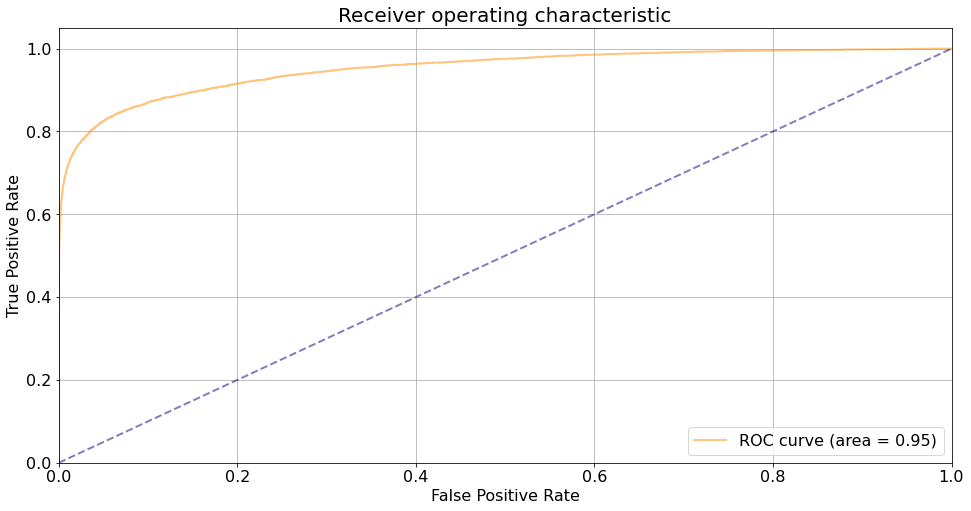

In [17]:
plt.figure(figsize=(16, 8))
lw=2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

### Результаты

Undersampling | Model | ROC-AUC | 
--- | --- | --- | 
|  |  | 
Random Sampler | CatBoost Classifier | 0.95 | 

In [18]:
pickle.dump(model, open(PATH+'catboost_classifier.pkl', 'wb'))